In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
from methods import IBU, NPU, MADE

import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfb = tfp.bijectors

2023-02-17 04:42:29.093117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 04:42:29.218886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 04:42:29.218904: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-17 04:42:31.557317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Generate data for W0 training (as well as theta)

bins = np.linspace(-5,5,11)
nbins = len(bins)-1

Ndata = 100000
Nsim = 10000000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0
sigma_data = 1.2
beta_data = 0
epsilon_data = 1

p = np.array([1./nbins for i in range(1, nbins+1)])

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R = []
for i in range(1,nbins+1):
    T_sim_i = T_sim[np.digitize(T_sim, bins)==i]
    R_sim_i = np.random.normal(T_sim_i+beta_sim,epsilon_sim)
    ms = np.array([(np.digitize(R_sim_i, bins)==i).sum()/len(T_sim_i) for i in range(1, nbins+1)])
    ms /= ms.sum() # should we normalize the total probablitiy to 1?
    R.append(ms)
R = np.transpose(np.array(R))

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
R_data = np.random.normal(T_data+beta_data,epsilon_data)
t = np.array([(np.digitize(T_data, bins)==i).sum() for i in range(1, nbins+1)])
m = np.array([(np.digitize(R_data, bins)==i).sum() for i in range(1, nbins+1)])

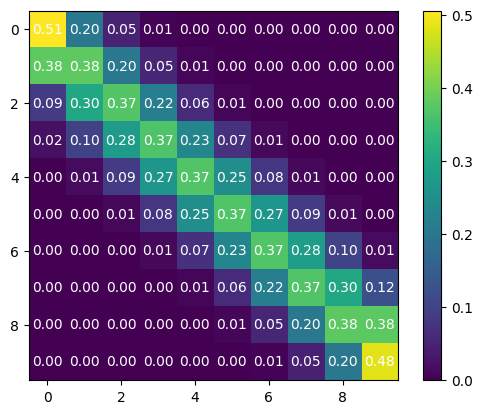

In [3]:
plt.imshow(R)
plt.colorbar()

for i in range(len(R)):
    for j in range(len(R)):
        text = plt.text(j, i, f"{R[i, j]:.2f}", ha="center", va="center", color="w")
        
plt.show()

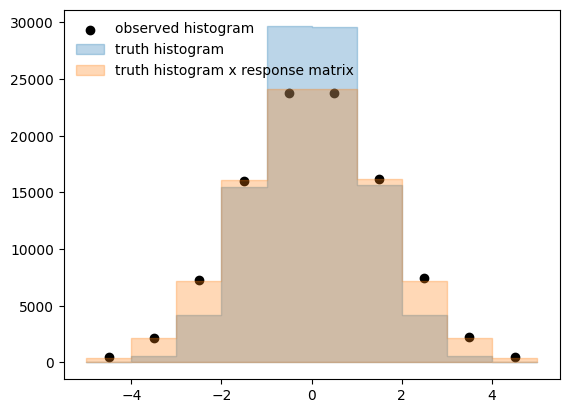

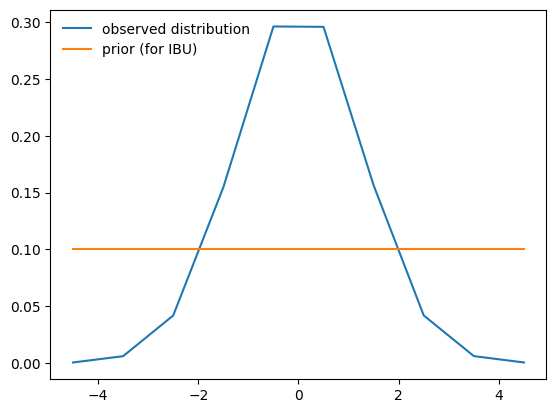

In [4]:
plt.scatter(0.5*(bins[1:]+bins[:-1]), m, color='black', label='observed histogram')
plt.fill_between(bins, np.insert(t, len(t), np.array(t[-1])), step='post', alpha=0.3, color='tab:blue', label='truth histogram')
plt.fill_between(bins, np.insert(np.matmul(R, t), len(np.matmul(R, t)), np.array(np.matmul(R, t)[-1])), step='post', alpha=0.3, color='tab:orange', label='truth histogram x response matrix')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

plt.plot(0.5*(bins[1:]+bins[:-1]), t/t.sum(), label='observed distribution')
plt.plot(0.5*(bins[1:]+bins[:-1]), p, label='prior (for IBU)')
plt.legend(frameon=False, loc="upper left")
plt.show()

In [15]:
def MLE(model,ymes,ndim):
    x = tf.Variable(ndim*[1.0/ndim])
    loss = lambda: -model.log_prob(x, bijector_kwargs={'conditional_input': ymes})
    losses = tfp.math.minimize(loss,
                               num_steps=10000,
                               #convergence_criterion=(
                               #     tfp.optimizers.convergence_criteria.LossNotDecreasing(atol=0.001)),
                               trainable_variables=[x],
                               optimizer=tf.optimizers.Adam(learning_rate=0.001))
    return x

def MADE(data_shape, cond_shape):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2,
                                     hidden_units=[50,50,50], #To be changed when using bigger histograms
                                     event_shape=data_shape,
                                     activation='swish',
                                     conditional=True,
                                     conditional_event_shape=cond_shape,
                                    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data_shape]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data_shape,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond_shape,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_,c_], log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss=lambda _, log_prob: -log_prob)
    return model, distribution

def NPU(ymes,Rin,N):
    #Inputs: 
    # ymes: Measured data provided in a histogram with M bins (M,)
    # Rin: Detector resolution matrix. First coordinate is the measured value and second coordinate is the truth level. (M,M)
    # N: Total number of observations
    #Returns samples from p(true|measured).  Would normally want the mode over true, which is equivalent to the MLE given p(true) is uniform.

    M = 1000000 # a big number - should make bigger later
    nsample = 1000
#     ts = np.random.dirichlet(np.ones(len(ymes)),size=M)*N
    ts = np.random.uniform(0,1,(M,len(ymes))) #M values with B bins
    ts=ts/np.sum(ts,-1,keepdims=True)*N

    ms = []
    for j in range(len(ts)):
        if j % 100000 == 0: print(f"{j}/{len(ts)}")
        m_hold = [np.random.poisson(ts[j][i]) for i in range(len(ts[j]))] #stat fluctuations
        m_holds = np.random.multinomial(m_hold[0],Rin[:,0])
        for i in range(1, len(ts[j])):
            m_holds += np.random.multinomial(m_hold[i],Rin[:,i])
        ms += [m_holds]
        pass
    ts = np.array(ts)
    ms = np.array(ms)

    n = len(ts)
    x = ms #conditional feature
    y = ts #learn p(y|x)
    nx = N
    ny = N

    #Normalize the total number of events to make the NF easier to train
    x = x/float(nx)
    y = y/float(ny)

    model,dist = MADE(y.shape[1],x.shape[1])
    # Fit.
    batch_size = 10000
    myhistory = model.fit([y,x],
                          y=np.zeros((len(x),0), dtype=np.float32), #dummy labels
                          batch_size=batch_size,
                          epochs=3000,
                          verbose = 1)

    plt.plot(myhistory.history['loss'][10:-1])
    plt.xlabel("epochs")
    plt.ylabel("loss")

    #mle = MLE(dist,ymes/float(nx),y.shape[-1])
    #print(mle)
    mle = MLE(dist,ymes/float(nx),y.shape[-1]).numpy()
    output = dist.sample(nsample, bijector_kwargs={'conditional_input': np.tile(ymes/float(nx),nsample).reshape([nsample,len(ymes)])}).numpy()
    return output*ny,mle*ny

99875
0/1000000
100000/1000000
200000/1000000
300000/1000000
400000/1000000
500000/1000000
600000/1000000
700000/1000000
800000/1000000
900000/1000000
Epoch 1/3000
100/100 [==============================] - 2s 11ms/step - loss: 8.8815
Epoch 2/3000
100/100 [==============================] - 1s 11ms/step - loss: 8.2397
Epoch 3/3000
100/100 [==============================] - 1s 11ms/step - loss: 7.2531
Epoch 4/3000
100/100 [==============================] - 1s 11ms/step - loss: 5.5191
Epoch 5/3000
100/100 [==============================] - 1s 11ms/step - loss: 2.5135
Epoch 6/3000
100/100 [==============================] - 1s 11ms/step - loss: -0.8098
Epoch 7/3000
100/100 [==============================] - 1s 11ms/step - loss: -3.3035
Epoch 8/3000
100/100 [==============================] - 1s 11ms/step - loss: -5.0283
Epoch 9/3000
100/100 [==============================] - 1s 11ms/step - loss: -6.3467
Epoch 10/3000
100/100 [==============================] - 1s 11ms/step - loss: -7.5625
Epo

100/100 [==============================] - 1s 12ms/step - loss: -20.8429
Epoch 94/3000
100/100 [==============================] - 1s 11ms/step - loss: -20.9318
Epoch 95/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.0142
Epoch 96/3000
100/100 [==============================] - 1s 12ms/step - loss: -21.1156
Epoch 97/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.2197
Epoch 98/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.3451
Epoch 99/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.4788
Epoch 100/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.6416
Epoch 101/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.8088
Epoch 102/3000
100/100 [==============================] - 1s 11ms/step - loss: -21.9970
Epoch 103/3000
100/100 [==============================] - 1s 12ms/step - loss: -22.1656
Epoch 104/3000
100/100 [=============================

100/100 [==============================] - 1s 11ms/step - loss: -25.1638
Epoch 187/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.1862
Epoch 188/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.2294
Epoch 189/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.2648
Epoch 190/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.2925
Epoch 191/3000
100/100 [==============================] - 1s 12ms/step - loss: -25.3168
Epoch 192/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.3448
Epoch 193/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.3914
Epoch 194/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.4220
Epoch 195/3000
100/100 [==============================] - 1s 11ms/step - loss: -25.4490
Epoch 196/3000
100/100 [==============================] - 1s 12ms/step - loss: -25.4803
Epoch 197/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -27.2989
Epoch 280/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.3026
Epoch 281/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.3274
Epoch 282/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.3265
Epoch 283/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.3490
Epoch 284/3000
100/100 [==============================] - 1s 12ms/step - loss: -27.3576
Epoch 285/3000
100/100 [==============================] - 1s 12ms/step - loss: -27.3773
Epoch 286/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.3968
Epoch 287/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.3983
Epoch 288/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.4107
Epoch 289/3000
100/100 [==============================] - 1s 11ms/step - loss: -27.4373
Epoch 290/3000
100/100 [=======================

100/100 [==============================] - 1s 12ms/step - loss: -28.6178
Epoch 373/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.6745
Epoch 374/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.6811
Epoch 375/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.7009
Epoch 376/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.7243
Epoch 377/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.7283
Epoch 378/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.7505
Epoch 379/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.7667
Epoch 380/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.7887
Epoch 381/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.8098
Epoch 382/3000
100/100 [==============================] - 1s 11ms/step - loss: -28.8288
Epoch 383/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -30.7185
Epoch 466/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7152
Epoch 467/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7292
Epoch 468/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7293
Epoch 469/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7650
Epoch 470/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7564
Epoch 471/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7786
Epoch 472/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.8040
Epoch 473/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.8042
Epoch 474/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.7959
Epoch 475/3000
100/100 [==============================] - 1s 11ms/step - loss: -30.8335
Epoch 476/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -31.5716
Epoch 559/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.5860
Epoch 560/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.5850
Epoch 561/3000
100/100 [==============================] - 1s 12ms/step - loss: -31.6116
Epoch 562/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.5974
Epoch 563/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.6330
Epoch 564/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.6317
Epoch 565/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.6244
Epoch 566/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.6330
Epoch 567/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.6697
Epoch 568/3000
100/100 [==============================] - 1s 11ms/step - loss: -31.6787
Epoch 569/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -32.3850
Epoch 652/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.4522
Epoch 653/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.4957
Epoch 654/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.4777
Epoch 655/3000
100/100 [==============================] - 1s 12ms/step - loss: -32.4925
Epoch 656/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.5039
Epoch 657/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.4979
Epoch 658/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.5216
Epoch 659/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.5236
Epoch 660/3000
100/100 [==============================] - 1s 11ms/step - loss: -32.5429
Epoch 661/3000
100/100 [==============================] - 1s 12ms/step - loss: -32.5478
Epoch 662/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -33.3996
Epoch 745/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.3130
Epoch 746/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.3903
Epoch 747/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.4235
Epoch 748/3000
100/100 [==============================] - 1s 12ms/step - loss: -33.3989
Epoch 749/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.4011
Epoch 750/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.4327
Epoch 751/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.4572
Epoch 752/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.4186
Epoch 753/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.3772
Epoch 754/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.5060
Epoch 755/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -34.0489
Epoch 838/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.0322
Epoch 839/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.0262
Epoch 840/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.0694
Epoch 841/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.9940
Epoch 842/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.1205
Epoch 843/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.0669
Epoch 844/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.0983
Epoch 845/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.0542
Epoch 846/3000
100/100 [==============================] - 1s 12ms/step - loss: -34.0871
Epoch 847/3000
100/100 [==============================] - 1s 11ms/step - loss: -33.9662
Epoch 848/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -34.5127
Epoch 931/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.4690
Epoch 932/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.4274
Epoch 933/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.4702
Epoch 934/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.4991
Epoch 935/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.4865
Epoch 936/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.4290
Epoch 937/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.5063
Epoch 938/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.3365
Epoch 939/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.5360
Epoch 940/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.5010
Epoch 941/3000
100/100 [=======================

100/100 [==============================] - 1s 11ms/step - loss: -34.6921
Epoch 1024/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.7919
Epoch 1025/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.8603
Epoch 1026/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.8561
Epoch 1027/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.7918
Epoch 1028/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.5427
Epoch 1029/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.8931
Epoch 1030/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.8363
Epoch 1031/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.9045
Epoch 1032/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.8357
Epoch 1033/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.8301
Epoch 1034/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -35.2191
Epoch 1116/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.1450
Epoch 1117/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.0418
Epoch 1118/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.1950
Epoch 1119/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.9512
Epoch 1120/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.2306
Epoch 1121/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.1660
Epoch 1122/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.0552
Epoch 1123/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.1391
Epoch 1124/3000
100/100 [==============================] - 1s 11ms/step - loss: -34.9936
Epoch 1125/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.2347
Epoch 1126/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -35.4470
Epoch 1208/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.3145
Epoch 1209/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.5048
Epoch 1210/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.3134
Epoch 1211/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.4779
Epoch 1212/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.3708
Epoch 1213/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.4770
Epoch 1214/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.3830
Epoch 1215/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.5053
Epoch 1216/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.4626
Epoch 1217/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.4138
Epoch 1218/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -35.7196
Epoch 1300/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.5707
Epoch 1301/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.8112
Epoch 1302/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.6656
Epoch 1303/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.5780
Epoch 1304/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.8219
Epoch 1305/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.6273
Epoch 1306/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.6671
Epoch 1307/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.7720
Epoch 1308/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.6536
Epoch 1309/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.6514
Epoch 1310/3000
100/100 [============

100/100 [==============================] - 1s 12ms/step - loss: -35.7003
Epoch 1392/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.0839
Epoch 1393/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.8839
Epoch 1394/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.7744
Epoch 1395/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.0748
Epoch 1396/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.8596
Epoch 1397/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.1097
Epoch 1398/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.8828
Epoch 1399/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.9451
Epoch 1400/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.9338
Epoch 1401/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.9997
Epoch 1402/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -36.0126
Epoch 1484/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.2053
Epoch 1485/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.3214
Epoch 1486/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.9314
Epoch 1487/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.3695
Epoch 1488/3000
100/100 [==============================] - 1s 11ms/step - loss: -35.5044
Epoch 1489/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.3088
Epoch 1490/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.3678
Epoch 1491/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.3221
Epoch 1492/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.0669
Epoch 1493/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.3830
Epoch 1494/3000
100/100 [============

100/100 [==============================] - 1s 12ms/step - loss: -36.0928
Epoch 1576/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.4245
Epoch 1577/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.6097
Epoch 1578/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.3433
Epoch 1579/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.6235
Epoch 1580/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.0340
Epoch 1581/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.6160
Epoch 1582/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.2775
Epoch 1583/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.5883
Epoch 1584/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.5907
Epoch 1585/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.4536
Epoch 1586/3000
100/100 [============

100/100 [==============================] - 1s 12ms/step - loss: -36.5141
Epoch 1668/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.8331
Epoch 1669/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.3564
Epoch 1670/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.8674
Epoch 1671/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.3240
Epoch 1672/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.8685
Epoch 1673/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.5659
Epoch 1674/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.7177
Epoch 1675/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.3625
Epoch 1676/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.8117
Epoch 1677/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.8601
Epoch 1678/3000
100/100 [============

100/100 [==============================] - 1s 12ms/step - loss: -36.8836
Epoch 1760/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.8983
Epoch 1761/3000
100/100 [==============================] - 1s 12ms/step - loss: -35.5288
Epoch 1762/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.8073
Epoch 1763/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.9886
Epoch 1764/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.0411
Epoch 1765/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.0859
Epoch 1766/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.1069
Epoch 1767/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.7498
Epoch 1768/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.9004
Epoch 1769/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.5725
Epoch 1770/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -36.1374
Epoch 1852/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.2310
Epoch 1853/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.2912
Epoch 1854/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.1139
Epoch 1855/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.6763
Epoch 1856/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.2776
Epoch 1857/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.0090
Epoch 1858/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.1916
Epoch 1859/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.0263
Epoch 1860/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.0887
Epoch 1861/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.2854
Epoch 1862/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -37.5017
Epoch 1944/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.2962
Epoch 1945/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.2242
Epoch 1946/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.0268
Epoch 1947/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.4975
Epoch 1948/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.2296
Epoch 1949/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.0554
Epoch 1950/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.5183
Epoch 1951/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.0750
Epoch 1952/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.9379
Epoch 1953/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.4752
Epoch 1954/3000
100/100 [============

100/100 [==============================] - 1s 12ms/step - loss: -37.6356
Epoch 2036/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.8003
Epoch 2037/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.6659
Epoch 2038/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.4993
Epoch 2039/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.4135
Epoch 2040/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.4772
Epoch 2041/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.8341
Epoch 2042/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.6179
Epoch 2043/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.6973
Epoch 2044/3000
100/100 [==============================] - 1s 12ms/step - loss: -36.7578
Epoch 2045/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.6491
Epoch 2046/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -37.4081
Epoch 2128/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.7528
Epoch 2129/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.6583
Epoch 2130/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.5728
Epoch 2131/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.5628
Epoch 2132/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.6271
Epoch 2133/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.1175
Epoch 2134/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.8087
Epoch 2135/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.8574
Epoch 2136/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.4036
Epoch 2137/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.2173
Epoch 2138/3000
100/100 [============

100/100 [==============================] - 1s 12ms/step - loss: -38.0317
Epoch 2220/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.0899
Epoch 2221/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.9946
Epoch 2222/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.9138
Epoch 2223/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.7967
Epoch 2224/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.4693
Epoch 2225/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.9288
Epoch 2226/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.3719
Epoch 2227/3000
100/100 [==============================] - 1s 12ms/step - loss: -38.0091
Epoch 2228/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.6300
Epoch 2229/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.8812
Epoch 2230/3000
100/100 [============

100/100 [==============================] - 3s 35ms/step - loss: -37.4714
Epoch 2312/3000
100/100 [==============================] - 3s 35ms/step - loss: -38.1343
Epoch 2313/3000
100/100 [==============================] - 4s 36ms/step - loss: -37.6704
Epoch 2314/3000
100/100 [==============================] - 4s 35ms/step - loss: -38.0943
Epoch 2315/3000
100/100 [==============================] - 3s 35ms/step - loss: -37.2791
Epoch 2316/3000
100/100 [==============================] - 4s 35ms/step - loss: -38.1076
Epoch 2317/3000
100/100 [==============================] - 3s 33ms/step - loss: -38.2004
Epoch 2318/3000
100/100 [==============================] - 3s 34ms/step - loss: -37.8572
Epoch 2319/3000
100/100 [==============================] - 3s 34ms/step - loss: -37.5359
Epoch 2320/3000
100/100 [==============================] - 3s 34ms/step - loss: -38.1993
Epoch 2321/3000
100/100 [==============================] - 3s 33ms/step - loss: -37.4267
Epoch 2322/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -37.5383
Epoch 2404/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.1199
Epoch 2405/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3435
Epoch 2406/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.7221
Epoch 2407/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3542
Epoch 2408/3000
100/100 [==============================] - 1s 12ms/step - loss: -37.8987
Epoch 2409/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.7231
Epoch 2410/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3370
Epoch 2411/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.1764
Epoch 2412/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.2695
Epoch 2413/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3490
Epoch 2414/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -37.9821
Epoch 2496/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3450
Epoch 2497/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.1012
Epoch 2498/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.9806
Epoch 2499/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.2300
Epoch 2500/3000
100/100 [==============================] - 1s 12ms/step - loss: -38.2462
Epoch 2501/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.1821
Epoch 2502/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.4080
Epoch 2503/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.4210
Epoch 2504/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.5054
Epoch 2505/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.9675
Epoch 2506/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -38.6416
Epoch 2588/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.3456
Epoch 2589/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.5751
Epoch 2590/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.6485
Epoch 2591/3000
100/100 [==============================] - 1s 11ms/step - loss: -36.7927
Epoch 2592/3000
100/100 [==============================] - 1s 12ms/step - loss: -38.5133
Epoch 2593/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.5821
Epoch 2594/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.6451
Epoch 2595/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.8184
Epoch 2596/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.6398
Epoch 2597/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.9677
Epoch 2598/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -38.0700
Epoch 2680/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.7406
Epoch 2681/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.0323
Epoch 2682/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.7619
Epoch 2683/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.8167
Epoch 2684/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.7388
Epoch 2685/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.1799
Epoch 2686/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.4551
Epoch 2687/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.6808
Epoch 2688/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.7482
Epoch 2689/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.8401
Epoch 2690/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -38.1333
Epoch 2772/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.8908
Epoch 2773/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.9868
Epoch 2774/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.8831
Epoch 2775/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3080
Epoch 2776/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.1409
Epoch 2777/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.6528
Epoch 2778/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.9052
Epoch 2779/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.1774
Epoch 2780/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.5942
Epoch 2781/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.2225
Epoch 2782/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -38.2080
Epoch 2864/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.9851
Epoch 2865/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.4094
Epoch 2866/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.0217
Epoch 2867/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.9587
Epoch 2868/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.0080
Epoch 2869/3000
100/100 [==============================] - 1s 11ms/step - loss: -37.7215
Epoch 2870/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.9375
Epoch 2871/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.0204
Epoch 2872/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.1145
Epoch 2873/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.0145
Epoch 2874/3000
100/100 [============

100/100 [==============================] - 1s 11ms/step - loss: -39.0608
Epoch 2956/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.1279
Epoch 2957/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.0418
Epoch 2958/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.0952
Epoch 2959/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.3437
Epoch 2960/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.0246
Epoch 2961/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.4549
Epoch 2962/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.8997
Epoch 2963/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.1365
Epoch 2964/3000
100/100 [==============================] - 1s 11ms/step - loss: -38.0844
Epoch 2965/3000
100/100 [==============================] - 1s 11ms/step - loss: -39.1334
Epoch 2966/3000
100/100 [============

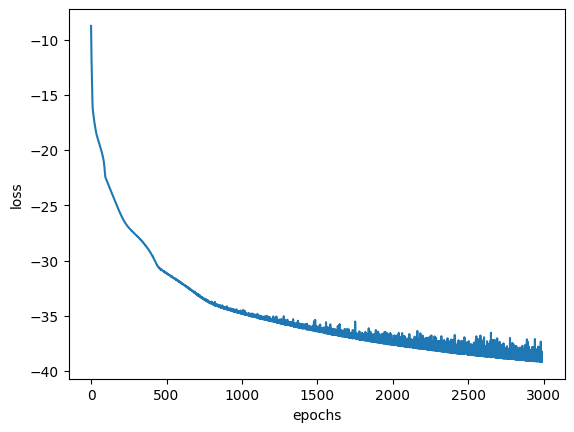

In [16]:
N = m.sum()
print(N)

npu,mle = NPU(m,R,N)

In [26]:
ibu = IBU(m,p,R,10)

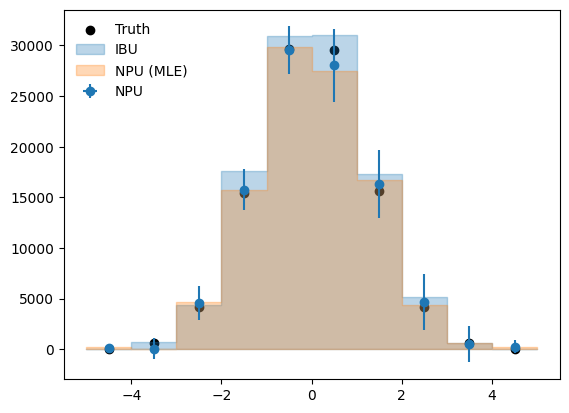

<Figure size 640x480 with 0 Axes>

In [27]:
# plt.scatter(list(0.5*(bins[1:]+bins[:-1]))*1000,npu.reshape(-1), marker='*', label="NPU",s=40)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), npu.mean(axis=0), xerr=0, yerr=npu.std(axis=0), label='NPU', marker='o', linestyle='None')
plt.scatter(0.5*(bins[1:]+bins[:-1]), t, color='black', label='Truth')
plt.fill_between(bins, np.insert(ibu, len(ibu), np.array(ibu[-1])), step='post', alpha=0.3, color='tab:blue', label='IBU')
plt.fill_between(bins, np.insert(mle, len(mle), np.array(mle[-1])), step='post', alpha=0.3, color='tab:orange', label='NPU (MLE)')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()